# Machine Learning for autonomous Robots

### Vamsi Krishna Origanti


Researcher, Terrestrial Robotics: Mobility & Manipulation  
DFKI GmbH  
Robotics Innovation Center  
Robert-Hooke-Straße 1  
28359 Bremen, Germany  
www.dfki.de/robotics

# Tutorial 11: Neural Networks III (RNNs)

- In this session a tutorial on using LSTM networks to predict time-series data will be presented.
- In this tutorial we will only deal with time-series data however the methods presented here can be applied for any sort of sequence modeling.

As a recap, Sequences for ML models are typically input as tensors/arrays having shape
**(samples, timesteps, features)**.



### Ruccurent Neural Network (RNN)
A **Recurrent Neural Network (RNN)**, is a kind of Neural Network that:
- handles sequential data and model temporal dependencies in the data
- it takes the output of a particular layer and feeding this back to the input in order to predict a new output 
- This is done through an internal state ($h$) that is persisted between timesteps.

<img src='pics/rnns.png' width="400" height="400">

- Assume $h_t$ is the hidden state for timestep $t$
- $x_t$ is the input given at timestep $t$,
- $y_t$ is the output produced at each timestep.
\begin{align*}
    h_t &= \sigma_h(W_{hh} h_{t-1} + W_{xh} x_t + b_h)\\
    y_t &= \sigma_y(W_{hy} h_t + b_y)
\end{align*}

$\sigma$ denotes activation functions.

### Back Propagation Through Time
<img src='pics/bptt.png' width="600" height="600">

#### Issues: Vanishing gradients

### Long-Short Term Memory - LSTM
An **LSTM** is a kind of **Recurrent Neural Network (RNN)**, that was introduced to:
- Model long-term dependencies in the sequence
- Mitigate the problem of vanishing gradient due to the unfolding through time process
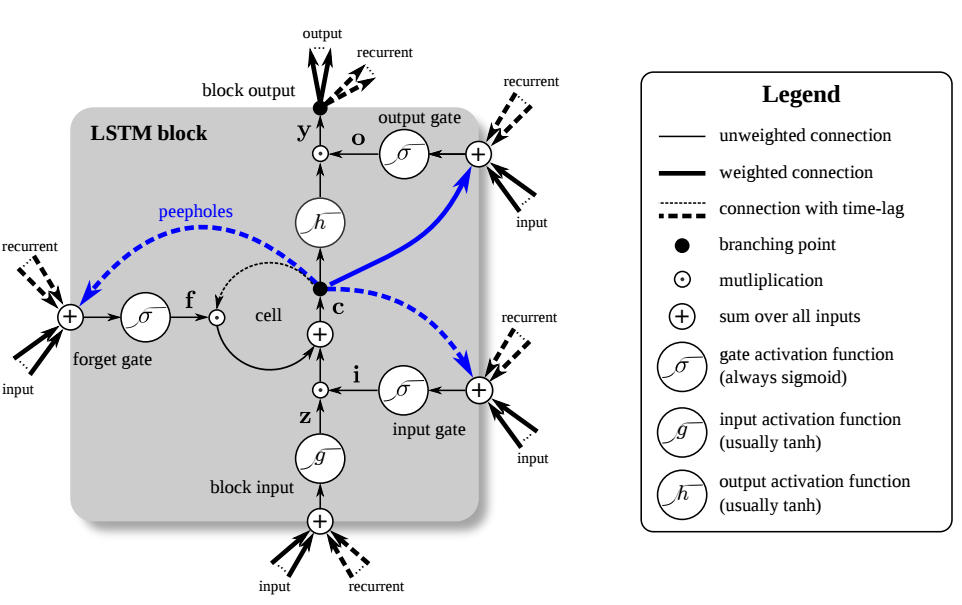

### LSTM Gates
The three gates (forget, input, output):
\begin{align*}
    g_f &= \sigma(W_{hf} h_{t-1} + W_{xf} x_t + b_f)\\
    g_i &= \sigma(W_{hi} h_{t-1} + W_{xi} x_t + b_i)\\
    g_o &= \sigma(W_{ho} h_{t-1} + W_{xo} x_t + b_o)\\
\end{align*}

## Problem Definition
The data we have at hand is the monthly number of airline passengers between 1946 and 1960. The problem is to predict for the next month, given past observations.

First we will take a look and the full dataset

In [9]:
!pip install pydot


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('airline-passengers.csv')

data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


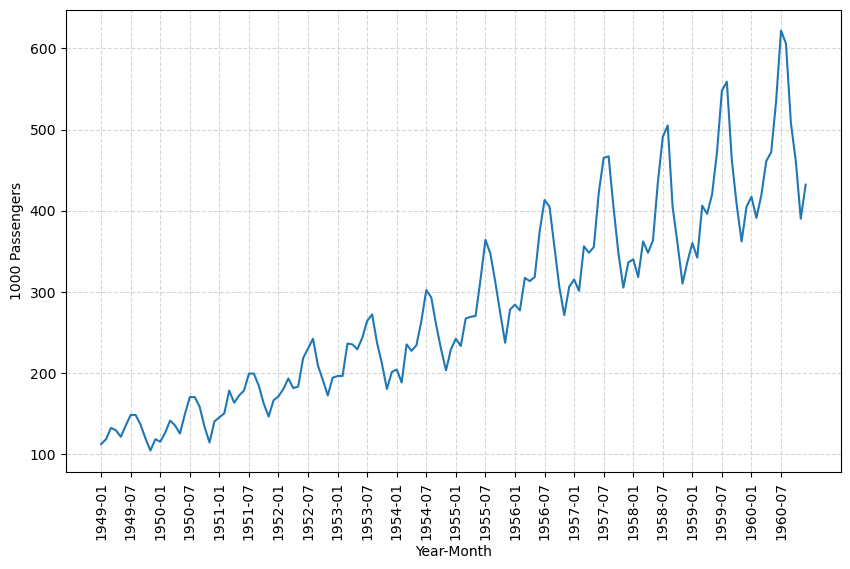

In [3]:
plt.figure(figsize=(10,6))
plt.grid(linestyle='--',alpha=0.5)
plt.plot(data['Month'],data['Passengers'])
idx = np.arange(0,len(data),6)
plt.xticks(idx,data['Month'][idx],rotation='vertical')
plt.xlabel('Year-Month')
plt.ylabel('1000 Passengers')
plt.show()

## What can you notice about this data?
- Periodic and globally increasing

## LSTM for Regression
Given the number of passengers for the current month or couple of past months, what is the value for the next month?

This can be viewed as a **one-to-one** or **many-to-one** prediction problem
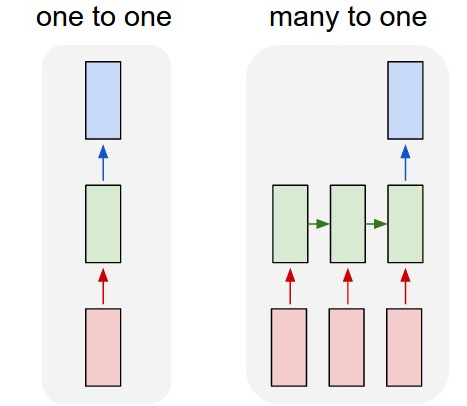

### Preprocessing
We first scale the data between [0,1] using a MinMaxScaler from scikit-learn library

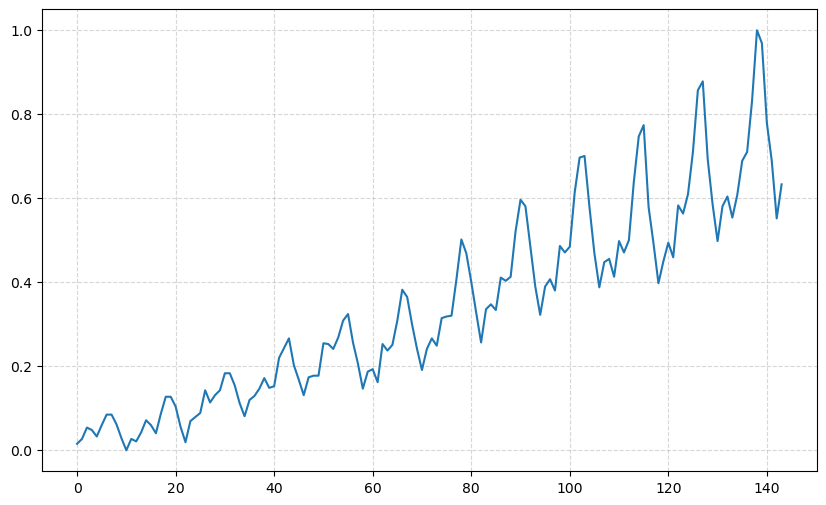

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

dataset = data['Passengers'].values

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:,None])

plt.figure(figsize=(10,6))
plt.grid(linestyle='--',alpha=0.5)
plt.plot(dataset)

### Train-test split

Next we split the data into 70% for training and 30% for testing

100 44


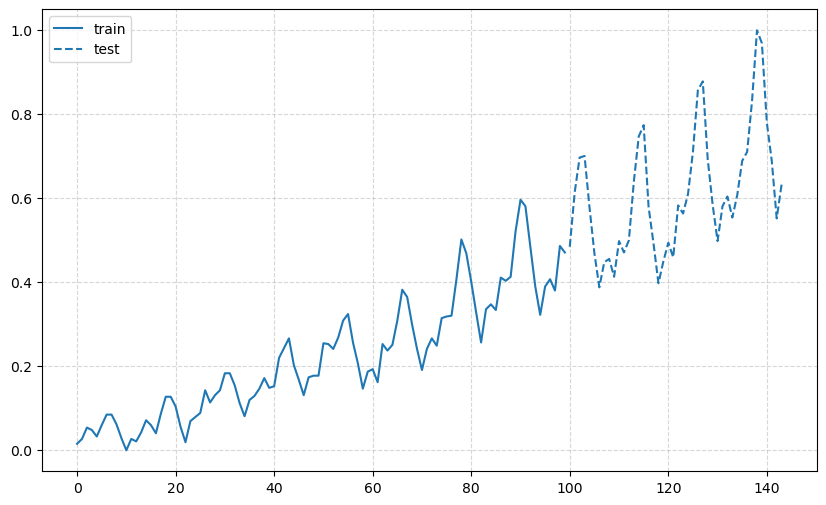

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

plt.figure(figsize=(10,6))
plt.grid(linestyle='--',alpha=0.5)
plt.plot(range(train_size),train, label='train')
plt.plot(range(train_size,len(dataset)),test, 'C0--',label='test')
plt.legend()

## Time-series transform

Next a function is required to transform the data into an overlapping time-series form where each sequence represents one sample prepended by its predecessors. The length of the sequence is thus the number of lookback samples. One sequence generated given a sample $x_i$ is then repesented as
$$\left[ x_{i-lb}, x_{i-lb+1}, ..., x_i\right]$$
where $lb$ is the lookback number of samples

In [6]:
def get_time_series(dataset, sequence_length=1):
    """ Transform data into time series
    Arguments:
        features: numpy.array, array of shape (n_samples_X, n_features)
        targets: numpy.array, array of shape (n_samples_X, n_targets)
        sequence_length: int, number of the lookback samples.
    Returns:
        numpy.array (n_samples-series_length, series_length, n_features),
        numpy.array (n_samples-series_length, n_targets)
    """
    X, y = list(), list()
    n_samples = dataset.shape[0]
    for i in range(n_samples):
        # find the end of this pattern
        end_ix = i + sequence_length
        # check if we are beyond the sequence
        if end_ix > n_samples:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = dataset[i:end_ix,:], dataset[end_ix-1,:]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 5
trainX, trainy = get_time_series(train, sequence_length)
testX, testy = get_time_series(test, sequence_length)
trainX.shape

(96, 5, 1)

## LSTM as regressor

The next step is to build an LSTM network to perform regression on the data described above.

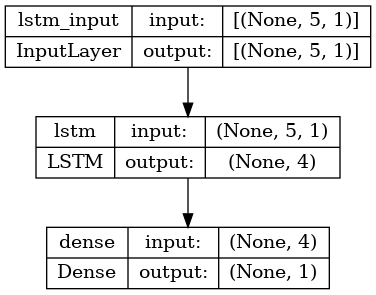

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.utils.vis_utils import plot_model

# create LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

plot_model(model, show_shapes=True, show_layer_names=True)

## Train the model
The created model can be trained using the fit function

In [8]:
model.fit(trainX, trainy, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
96/96 - 1s - loss: 0.0165 - 914ms/epoch - 10ms/step
Epoch 2/100
96/96 - 0s - loss: 0.0067 - 101ms/epoch - 1ms/step
Epoch 3/100
96/96 - 0s - loss: 0.0050 - 85ms/epoch - 882us/step
Epoch 4/100
96/96 - 0s - loss: 0.0040 - 83ms/epoch - 863us/step
Epoch 5/100
96/96 - 0s - loss: 0.0031 - 114ms/epoch - 1ms/step
Epoch 6/100
96/96 - 0s - loss: 0.0027 - 114ms/epoch - 1ms/step
Epoch 7/100
96/96 - 0s - loss: 0.0024 - 90ms/epoch - 937us/step
Epoch 8/100
96/96 - 0s - loss: 0.0022 - 80ms/epoch - 838us/step
Epoch 9/100
96/96 - 0s - loss: 0.0021 - 89ms/epoch - 927us/step
Epoch 10/100
96/96 - 0s - loss: 0.0022 - 88ms/epoch - 914us/step
Epoch 11/100
96/96 - 0s - loss: 0.0020 - 101ms/epoch - 1ms/step
Epoch 12/100
96/96 - 0s - loss: 0.0019 - 78ms/epoch - 811us/step
Epoch 13/100
96/96 - 0s - loss: 0.0020 - 107ms/epoch - 1ms/step
Epoch 14/100
96/96 - 0s - loss: 0.0018 - 86ms/epoch - 897us/step
Epoch 15/100
96/96 - 0s - loss: 0.0018 - 117ms/epoch - 1ms/step
Epoch 16/100
96/96 - 0s - loss: 0.0017 -

## Predictions
Let's perform a prediction on both the training and test sets and calculate the Root-Mean-Squared-Error (RMSE) and the Corefficient of determination $R^2$

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y_i-\hat{y}_i\right)^2}$$
$$R^2 = 1- \frac{\sum_{i=1}^{n}\left(y_i-\hat{y}_i\right)^2}{\sum_{i=1}^{n}\left(y_i-\bar{y}\right)^2}$$

In [9]:
from sklearn import metrics

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainTargets = scaler.inverse_transform(trainy).reshape(trainy.shape[0])
testPredict = scaler.inverse_transform(testPredict)
testTargets = scaler.inverse_transform(testy).reshape(testy.shape[0])
# calculate root mean squared error
trainScore = np.sqrt(metrics.mean_squared_error(trainTargets, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(metrics.mean_squared_error(testTargets, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# calculate R2 score
trainR2 = metrics.r2_score(trainTargets, trainPredict[:,0])
print('Train R2 Score: %.2f' % (trainR2))
testR2 = metrics.r2_score(testTargets, testPredict[:,0])
print('Test R2 Score: %.2f' % (testR2))

2/2 [==============================] - 0s 2ms/step
Train Score: 2.04 RMSE
Test Score: 5.79 RMSE
Train R2 Score: 1.00
Test R2 Score: 0.99


## Plotting
Finally let's plot the predictions

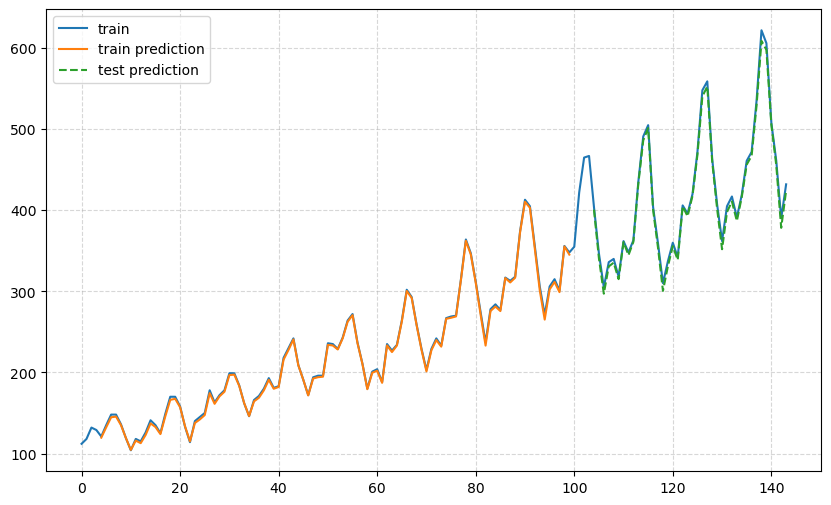

In [10]:
plt.figure(figsize=(10,6))
plt.grid(linestyle='--',alpha=0.5)
plt.plot(data['Passengers'], label='train')
plt.plot(range(sequence_length-1,train_size),trainPredict[:,0],
         label='train prediction')
plt.plot(range(train_size+sequence_length-1,len(dataset)),testPredict[:,0], '--',
         label='test prediction')
plt.legend()

### Exercise: LSTM for Learning the Dynamic Model of and Underwater Vehicle
<img src='pics/dagon-thrusters.png' width="500" height="500">

- Model
$$\dot{\nu} = f(\nu, u)$$
- Variables
\begin{align*}
\text{Velocity} & & \nu &= [u,v,r]\\
\text{Motor rpms}& & u &= [n_1,n_2,n_3]\\
\text{Accelerations}& & \dot{\nu} &= [\dot{u},\dot{v},\dot{r}]
\end{align*}

In [11]:
data = pd.read_csv('dagon_dataset.csv', delimiter=',', header=0)
data.head()

,u,v,r,th1,th2,th3,udot,vdot,rdot
0,0.018734,0.019025,0.050737,-0.236713,-0.000000,-0.13158,-0.023438,-0.000066,0.002008
1,0.014381,0.019048,0.051718,-1.175015,-0.885806,-0.13158,-0.025660,0.000755,0.007141
2,0.008226,0.018325,0.054058,-3.507889,-2.879224,-0.13158,-0.025996,-0.000004,0.012839
3,0.001826,0.018025,0.057688,-5.787881,-4.893686,-0.13158,-0.026938,-0.000456,0.018821
4,-0.007847,0.018823,0.062815,-8.069207,-6.883151,-0.13158,-0.028255,0.001126,0.024735


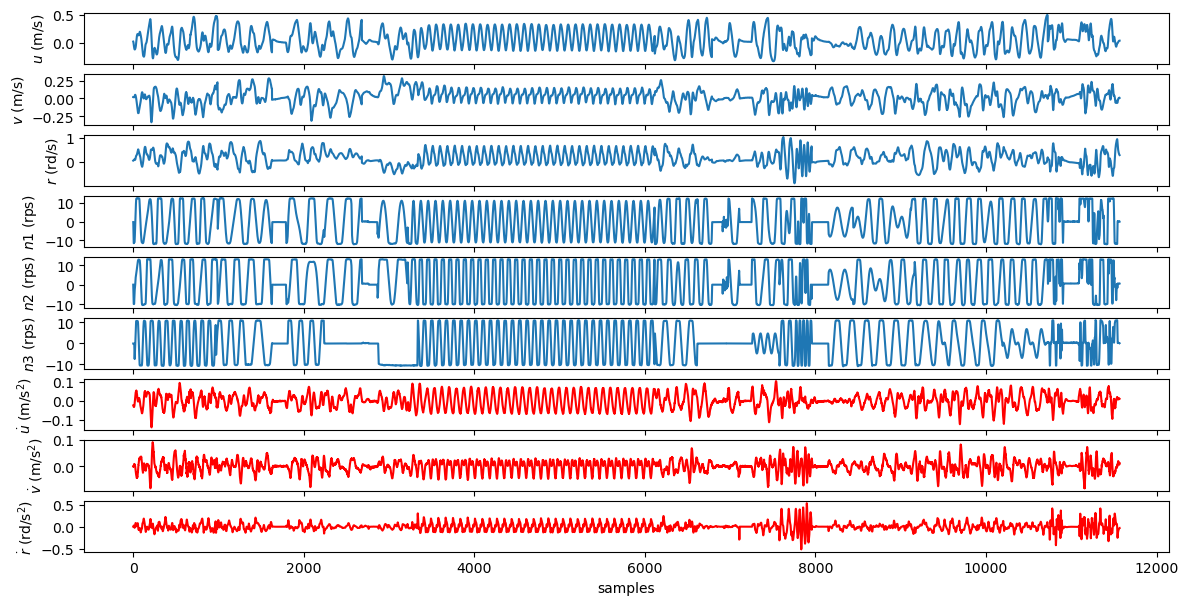

In [12]:
dataset = data.values
f, axarr = plt.subplots(9, sharex=True,figsize=(14,7))
labels = [r'$u$ (m/s)', r'$v$ (m/s)',r'$r$ (rd/s)',r'$n1$ (rps)', r'$n2$ (rps)', r'$n3$ (rps)',
         r'$\dot{u}$ (m/s$^2$)', r'$\dot{v}$ (m/s$^2$)',r'$\dot{r}$ (rd/s$^2$)']
for i in range(9):
    if i<6:
        axarr[i].plot(dataset[:,i])
    else:
        axarr[i].plot(dataset[:,i],'r')
    axarr[i].set_ylabel(labels[i])

plt.xlabel('samples')
plt.show()

Tasks:
- Design an LSTM to learn the relation between the inputs and outputs
- Use standard scaler instead of MinMax
- Train/test split 60/40
- Explore many-to-many vs. many-to-one designs
- Report $R^2$ and RMSE scores